# Reporte Tarea 5: Funciones,Modelos personalizados y EDOS


 De acuerdo a la teoría en el procesamiento de imagenes, podemos darle distintos colores a las imagenes de acuerdo a la profundidad de color (número de bits que posea un pixel)podemos representar n cantidad de colores, la profundidad de colores que necesitamos en este caso correspone a 8 bits, que son un total de 256 tonos de grises.
 En nuestro caso partimos de imagenes RGB que supongo que tambien son 8 bist pero a color, tambien 256 tonos de color).

En lugar de entrenar densamente y predecir la colorización de toda la imagen en una sola pasada, la CNN se entrena en muestras espacialmente escasas de parches en escala de grises de tamaño igual al campo receptivo de la red, prediciendo el valor de color del píxel central.
 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import mnist_loader
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread
from PIL import Image
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop,Adam


In [3]:
class Capgris(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        tr_d, va_d, te_d = mnist_loader.load_data()
        resha=tr_d[0][0] # primera imagen
        im=np.reshape(resha,(28,28)) 
        resha=np.reshape(im,(784,1)) #La reacomodamos como matriz de (784,1) para poderla meter a la red
        imtest=imread('Numero3.jpg') #Leemos nuestra imagen
        plt.imshow(imtest) #La visualizamos
        imtest=np.reshape(imtest,(784,3)) # La convertimos en vector
            #Convertimos a blanco y negro la imagen:
        lst = []
        for i in imtest:
            pix=i[0]*0.299+i[1]*0.587+i[2]*0.114#transfomamos a escala de grises, aquí dependiendo el valor con el que escalamos, es la tonalidad de grises
        if(pix<125):
            pix=0. #Como la hoja es blanca y el papel negro, lo negro lo ponemos con mayor luminosidad
        else:
            pix=0. #lo blanco lo ponemos como negro
            lst.append(pix)
            imtest=np.array(lst).reshape(1,28,28,3) #acomodamos la imagen para poder ver como quedó
            imtest=(imtest/imtest.max()) #normalizamos
            plt.imshow(imtest) #visualizamos la imagen


ValueError: cannot reshape array of size 1 into shape (1,28,28,3)

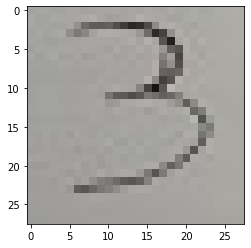

In [4]:
model_capgris=Capgris()

Forma alterna:

In [5]:
class Capgris2(Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def call(self,inputs):
        R,B,G=inputs[:,:,:,0],inputs[:,:,:,2],inputs[:,:,:,1]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        return imgGray


In [6]:
iage='descarga.png'
iage=tf.keras.preprocessing.image.load_img(iage)
iage=tf.keras.preprocessing.image.img_to_array(iage)

In [7]:
model=tf.keras.Sequential(Capgris2(iage))#no supe como mostrar la imagen

TypeError: Capgris2.__init__() takes 1 positional argument but 2 were given

In [8]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()
@property
def metrics(self):
    return [self.loss_tracker]

def train_step(self, data):
    batch_size = tf.shape(data)[0]
    min = tf.cast(tf.reduce_min(data),tf.float32)
    max = tf.cast(tf.reduce_max(data),tf.float32)
    x = tf.random.uniform((batch_size,1), minval=min, maxval=max)
    with tf.GradientTape() as tape:
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            y_pred = self(x, training=True)
            dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
            x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
            y_o = self(x_o,training=True) #valor del modelo en en x_0
            eq = dy + 2.*x*y_pred #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
            ic = 1. #valor que queremos para la condicion inicial o el modelo en x_0
            loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Apply grads
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result()}

In [11]:
model = ODEsolver()

model.add(Dense(10, activation='tanh', input_shape=(1,)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(15, activation='tanh'))
model.add(Dense(7, activation='tanh'))
model.add(Dense(1))


model.summary()

Model: "od_esolver_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                20        
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 15)                165       
                                                                 
 dense_6 (Dense)             (None, 7)                 112       
                                                                 
 dense_7 (Dense)             (None, 1)                 8         
                                                                 
Total params: 415
Trainable params: 415
Non-trainable params: 0
_________________________________________________________________


In [18]:
x = tf.linspace(-1,1,500)
y=3*np.sin(np.pi*x)
model.compile(loss='mean_squared_error',optimizer= 'adam')

model.fit(x, y, epochs=1000, batch_size=1,verbose=0)

yf=model.predict(x)

16/16 [==============================] - 0s 885us/step


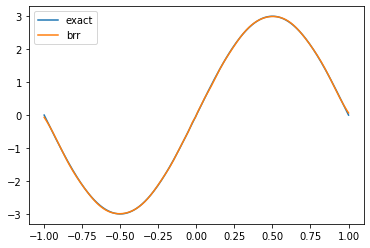

In [20]:
plt.plot(x,y,label="exact")
plt.plot(x,yf,label="brr")
plt.legend()
plt.show()

In [26]:
x1 = tf.linspace(-1,1,500)
y1=1+2*x+4*x**3
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.001))

model.fit(x1, y1, epochs=1000, batch_size=1,verbose=0)

yf2=model.predict(x1)

16/16 [==============================] - 0s 1ms/step


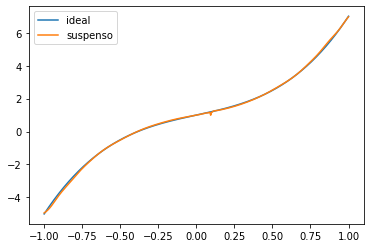

In [27]:
plt.plot(x1,y1,label="ideal")
plt.plot(x1,yf2,label="suspenso")
plt.legend()
plt.show()

In [30]:
class PolynomialLayer(Layer):
    def __init__(self, **kwargs):
        super(PolynomialLayer, self).__init__(**kwargs)

    def build(self, input_shape):# Damos los parámetros entrenables del polinomio :a,b,c,d
        self.a = self.add_weight("a", shape=(), initializer="zeros", trainable=True)
        self.b = self.add_weight("b", shape=(), initializer="zeros", trainable=True)
        self.c = self.add_weight("c", shape=(), initializer="zeros", trainable=True)
        self.d = self.add_weight("d", shape=(), initializer="zeros", trainable=True)
        super(PolynomialLayer, self).build(input_shape)

    def call(self, x):
        # Calcula el polinomio 
        return self.a + self.b * x + self.c * x**2 + self.d * x**3

In [31]:
model = Sequential()
model.add(PolynomialLayer(input_shape=(1,0)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 polynomial_layer_1 (Polynom  (None, 1, 0)             4         
 ialLayer)                                                       
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.001))
x2 = tf.linspace(-1,1,100)
y22=np.cos(2*x2)


model.fit(x2, y22, epochs=1000, batch_size=1,verbose=0)
yf22=model.predict(x2)


4/4 [==============================] - 0s 2ms/step


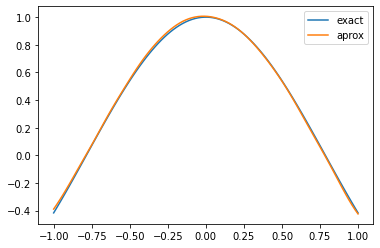

In [43]:
plt.plot(x2,y22,label="exact")
plt.plot(x2,yf22,label="aprox")
plt.legend()
plt.show()

In [40]:
model = ODEsolver()

model.add(Dense(10, activation='tanh', input_shape=(1,)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(15, activation='tanh'))
model.add(Dense(7, activation='tanh'))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.001))



Model: "od_esolver_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                20        
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 15)                165       
                                                                 
 dense_11 (Dense)            (None, 7)                 112       
                                                                 
 dense_12 (Dense)            (None, 1)                 8         
                                                                 
Total params: 415
Trainable params: 415
Non-trainable params: 0
_________________________________________________________________


In [65]:

x4 = tf.linspace(-5,5,500)
y4= x4*np.sin(x4) -2.*(-x4*np.cos(x4) + np.sin(x4))/ x4
model.fit(x4,y4,epochs=1030, batch_size=1,verbose=0)
y44=model.predict(x4)


16/16 [==============================] - 0s 1ms/step


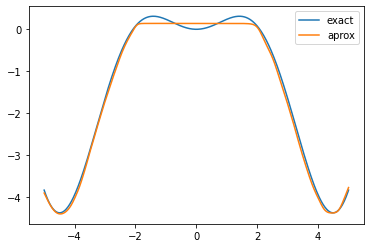

In [67]:
plt.plot(x4,y4,label="exact")
plt.plot(x4,y44,label="aprox")
plt.legend()
plt.show()


In [70]:
yn=tf.cos(x4)-0.5*tf.sin(x4)
model.fit(x4,yn,epochs=1030, batch_size=1,verbose=0)
ynn=model.predict(x4)

16/16 [==============================] - 0s 2ms/step


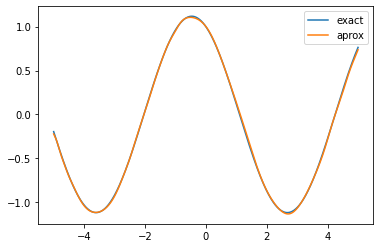

In [71]:
plt.plot(x4,yn,label="exact")
plt.plot(x4,ynn,label="aprox")
plt.legend()
plt.show()


Para ser franca creo que ha sido el reporte y la actividad que más me ha costado hasta ahora porque me intimidó leer lo que nos pedían, de ahí me hice bolas con lo del proesamiento de imagenes y con lo de las EDOS, creo que lo que más me costó es que ocasionalmente olvidaba la variable que daba para trabajar con cierto rango por lo que obtuve en más ocasiones de las que me gustaría el error "ValueError: Target data is missing. Your model was compiled with loss=mean_squared_error, and therefore expects target data to be provided in `fit()"
o ajustaba la x que no era.
Pero creo que mas o menos me familiaricé más con las capas.
Perdón por enviarlo tan tarde.